# Molecular Formula Attribution from Isotopic pattern

This notebook presents how to implement a molecular formula attribution considering
a <sup>13</sup>C isotopic pattern.

On the first cell of this notebook, the libraries to perform the Ion Molecular Formula Assignment are loaded.

In [1]:
# this cell import the need modules
import matplotlib.pyplot as plt

from pyc2mc.core.formula_grid import FormulaGrid
from pyc2mc.processing.standard_attribution import isotopic_pattern_attribution
from pyc2mc.io.peaklist import read_peaklist
from pyc2mc.plotinator.widgenator import display_chem_classes, display_error

## 1. Create the Molecular Formula Grid 

This grid aims to contains all the possible molecular formula assuming
some constrains including the number of each element and the presence or
not of some isotopes. 

### Set up the grid

In order to set up the grid you have to define the constrains which are
used to define the `FormulaGrid` class. The parameters are:

* `elements`: list of elements, at least C and H.
* `limits`: minimum and maximum number of each element
* `H_C_bounds`: boundaries of the H over C ratio
* `dbe_bouds`: boundaries of the DBE (Double Bond Equivalent)
* `mass_bounds`: boundaries of the nominal masses
* `polarity`: ionization charge

Additionally you can consider the two following options:

* `element_ratio`: boundaries of the ELM1 to ELM2 ratio as a dictionary.
* `isotopes`: dictionary of isotopes to be included in the formula list, see below
* `combine_isotopes`: list of dictionaries that defines combinations

Here is the syntax:

In [2]:
fgrid_example1 = FormulaGrid(
    # default element symbols
    elements=["C", "H", "N"],
    # [min, max] value of each element in the same order
    limits=[[1, 20], [1, 100], [0, 2]],
    # boundaries of the H over C ration
    H_C_bounds=[0.2, 3],
    # boundaries of DBE
    dbe_bounds=[0, 50],
    # boundaries of nominal mass
    mass_bounds=[50, 200],
    polarity=1,
)

### Select isotopes

If you want to consider isotopes, you have to define which ones you want
to consider and in which quantity.

For example, in the following we will consider formula that include
* one $^{13}C$
* two $^{13}C$
* one $^{15}N$
* one $^{18}O$

The syntax is the following

```python
isotopes = {
    (6, 13): 2,  # one & two atoms of 13C
    (7, 15): 1,  # one atom of 15N
    (8, 18): 1,  # one atom of 18O 
}
```

On each line we have

```python
(atomic_number, mass_number): number_of_isotope,
```

Here is the definition:

In [3]:
# define the considered isotopes 
# {(Atomic_number, mass_number, position): number_of_isotopes, ...}
isotopes = {
    (5, 10): 1,  # one atom of 10B
    (6, 13): 2,  # one and two atoms of 13C
    (8, 18): 1,  # one atom of 18O
}

Now we define the formula grid:

In [4]:
fgrid_example1 = FormulaGrid(
    # default element symbols
    elements=["C", "H", "N", "O", "B"],
    # [min, max] value of each element in the same order
    limits=[[1, 100], [1, 200], [0, 2], [0, 20], [0, 1]],
    # boundaries of the H over C ration
    H_C_bounds=[0.3, 2.4],
    # boundaries of DBE
    dbe_bounds=[0, 50],
    # boundaries of nominal mass
    mass_bounds=[150, 1000],
    polarity=-1,
    # O over C ratio
    element_ratios={('O', 'C'): (0, 1.4)},
    # define selected isotopes
    isotopes=isotopes,
    combine_isotopes=[{(5, 10): 1,(6, 13): 1}]
)

## 2. Read and plot a PeakList file

The assignment will be done from a peak list contained in a CSV file. You
have to provide the *path* (namely the location) of the file on your 
computer. The easiest way is to put the data in the same folder of the 
notebook or in a subfolder.

In this example, the [Biofuel_withB-containingSpecies file](./data/Biofuel_withB-containingSpecies.csv)
will be used.

Depending of the format of the data, consider to use one of the following
syntaxes.

In [5]:
# reading from predator file
input_path='./data/Biofuel_withB-containingSpecies.csv'
pl_B = read_peaklist(
    input_path,
    fmt="predator"
)

# ASCII
# input_path = 'data/ESI_pos_pH3_HULIS_darkAged.asc'
# pl = read_peaklist(input_path, fmt="ascii")

# input_path = 'file.pks'
# pl = read_peaklist(input_path, fmt="pks", skiprows=8)
# pl = read_pks(input_path, fmt="pks")

Plot the data read from the peak list file:

In [6]:
pl_B.plot(rug=True)

## 3. Performing the attribution 

Here we will perform the attribution using the Ion Molecular Formula Assignment 
Algorithm which searches the presence of $^{13}C_{1}$ isotopic patterns.

To perform the attribution you have to provide:

* the previously set formula grid
* the peak list
* the error width in ppm used to define if a m/z value is associated to a formula

Optionally you can define mass boundaries to limit the assignment to a mass range.

By default, the attribution is done by considering peak in decreasing S/N values. 
If S/N is not available, the algorithm will used the intensity. 
To work with intensities, the instruction must be `use_SN=False`.

In [7]:
attributed_peaklist = isotopic_pattern_attribution(
    peaklist=pl_B,
    formula_grid=fgrid_example1,
    lambda_parameter=0.3,
    use_isotopes=True
)

You can also run the `lowest_error_attribution` method, which attributes candidates by selecting the smallest error instead of using the isotopic pattern condition to do that. The following cell shows a syntax to execute this:

In [8]:
# attributed_peaklist2 = lowest_error_attribution(
#     peaklist=pl_B,
#     formula_grid=fgrid_example1,
#     lambda_parameter=0.3,
#     use_isotopes=True
# )

Compute the percentage of peaks for which a formula was identified including isotopes it also shows the existing candidates found:

In [9]:
attributed_peaklist.summary()

 Attribution results:
 Total number of peaks: 17667
 Attributed peaks     : 13344
 Mean error (ppm)     : 0.01435
 Std error (ppm)      : 0.09802
 Attributed percentage: 75.53 %
 hits percentage      : 95.4 %


The attribution statistics give an overview of how the peaks were attributed. The
meaning of the *method* column is the following:

* *hits*: attributed peaks
* *no_hits*: non attributed peaks
* *isotopes*: peaks attributed as isotopes of a previously attributed monoisotopic peak
* *isotopic_pattern*: monoisotopic peaks attributed by considering the existence of the isotopic pattern.
* *lowest_error*: peaks attributed by lowest error.

The columns *intensity* and *percentage* give the amount of the total intensity of the spectra which is attributed in each case.

In [10]:
attributed_peaklist.get_attribution_stats()

# peaks    % peaks   intensity  percentage
method                                                      
hits                13344   75.53065  3366.56311   95.398369
no_hits              4323   24.46935   162.38937    4.601631
isotopes             5138   29.08247   694.65001   19.684312
isotopic_pattern     1516    8.58097  2085.08093   59.084982
lowest_error         6690   37.86721   586.83217   16.629075
total               17667  100.00000  3528.95248  100.000000

In [11]:
attributed_peaklist.plot.plot_attribution_stats()

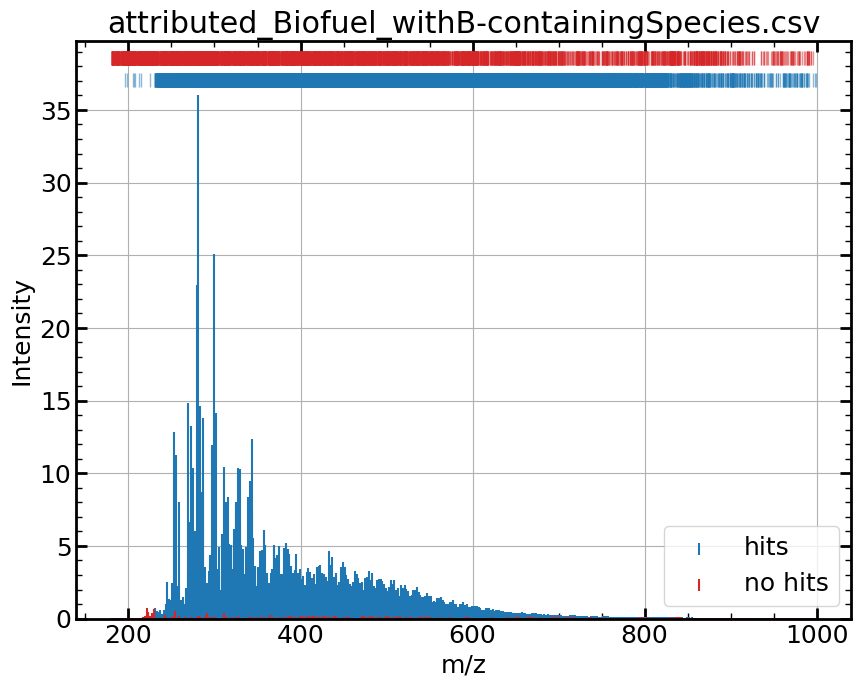

In [12]:
attributed_peaklist.plot(rug=True)

The results are contained in a data frame otained from the method `to_dataframe()` in the attributed_peaklist. To display only attributed peaks use `attributed_only=True`.

Here are the first 10 lines of the attributed data frame.

In [13]:
attributed_peaklist.to_dataframe(attributed_only=True).head(10)

mz  intensity           formula  polarity      SN  error_ppm  \
17318  196.21967    0.02720           C14 H28        -1  4.1354  -0.104563   
6661   198.05202    0.02824      C14 H5 N1 B1        -1  4.3406   0.167178   
15614  205.02280    0.03390       C6 H7 O7 N1        -1  3.3179   0.000717   
6538   206.20850    0.02866     C13 H25 N1 B1        -1  2.6520   0.260682   
7124   208.04894    0.02715       C9 H8 O4 N2        -1  2.4610   0.073660   
6928   212.20653    0.02753  C11 H25 O1 N2 B1        -1  2.5095   0.058334   
8791   214.98328    0.02729          C7 H3 O8        -1  2.4785   0.282037   
17531  225.17792    0.02682  C11 H22 O2 N2 B1        -1  2.4185   0.274901   
7532   231.02990    0.03820         C12 H7 O5        -1  3.8639  -0.013403   
8868   231.05103    0.04263         C9 H11 O7        -1  4.4272  -0.016137   

       attributed attribution_method  
17318        True       lowest_error  
6661         True       lowest_error  
15614        True       lowest_error  
6538         True       lowest_error  
7124         True       lowest_error  
6928         True       lowest_error  
8791         True       lowest_error  
17531        True       lowest_error  
7532         True       lowest_error  
8868         True       lowest_error

With the option `full_data=True` it is possible to get a more complete information about
the attributed peak list.

In [14]:
attributed_peaklist.to_dataframe(attributed_only=True, full_data=True).head(10)

mz  intensity           formula  polarity      SN  error_ppm  \
17318  196.21967    0.02720           C14 H28        -1  4.1354  -0.104563   
6661   198.05202    0.02824      C14 H5 N1 B1        -1  4.3406   0.167178   
15614  205.02280    0.03390       C6 H7 O7 N1        -1  3.3179   0.000717   
6538   206.20850    0.02866     C13 H25 N1 B1        -1  2.6520   0.260682   
7124   208.04894    0.02715       C9 H8 O4 N2        -1  2.4610   0.073660   
6928   212.20653    0.02753  C11 H25 O1 N2 B1        -1  2.5095   0.058334   
8791   214.98328    0.02729          C7 H3 O8        -1  2.4785   0.282037   
17531  225.17792    0.02682  C11 H22 O2 N2 B1        -1  2.4185   0.274901   
7532   231.02990    0.03820         C12 H7 O5        -1  3.8639  -0.013403   
8868   231.05103    0.04263         C9 H11 O7        -1  4.4272  -0.016137   

       attributed attribution_method  nominal_mass  kendrick_mass  ...  \
17318        True       lowest_error           196     196.000568  ...   
6661         True       lowest_error           198     197.830872  ...   
15614        True       lowest_error           205     204.793869  ...   
6538         True       lowest_error           206     205.978245  ...   
7124         True       lowest_error           208     207.816630  ...   
6928         True       lowest_error           212     211.969577  ...   
8791         True       lowest_error           215     214.743227  ...   
17531        True       lowest_error           225     224.926483  ...   
7532         True       lowest_error           231     230.771929  ...   
8868         True       lowest_error           231     230.793035  ...   

       isotopic  chem_group chem_group_mono chem_class chem_class_mono   C  \
17318     False          HC              HC         HC              HC  14   
6661      False         N B             N B      N1 B1           N1 B1  14   
15614     False         O N             O N      O7 N1           O7 N1   6   
6538      False         N B             N B      N1 B1           N1 B1  13   
7124      False         O N             O N      O4 N2           O4 N2   9   
6928      False       O N B           O N B   O1 N2 B1        O1 N2 B1  11   
8791      False           O               O         O8              O8   7   
17531     False       O N B           O N B   O2 N2 B1        O2 N2 B1  11   
7532      False           O               O         O5              O5  12   
8868      False           O               O         O7              O7   9   

        H  O  N  B  
17318  28  0  0  0  
6661    5  0  1  1  
15614   7  7  1  0  
6538   25  0  1  1  
7124    8  4  2  0  
6928   25  1  2  1  
8791    3  8  0  0  
17531  22  2  2  1  
7532    7  5  0  0  
8868   11  7  0  0  

[10 rows x 21 columns]

The results can be exported to excel or csv files either using directly
the pandas functions on the data frame obtained from `to_dataframe()`, or,
using the `to_csv` methods of the `AttributedPeakList` object.

```python
# output filename
filename='Biofuel_B-containing.csv'
attr_pl.to_viewer(filename)
# attr_pl.to_csv(filename)
```

## 4. Plot some results

An attributed peak list object has the following properties:

In [15]:
attributed_peaklist.plot.plot_error()

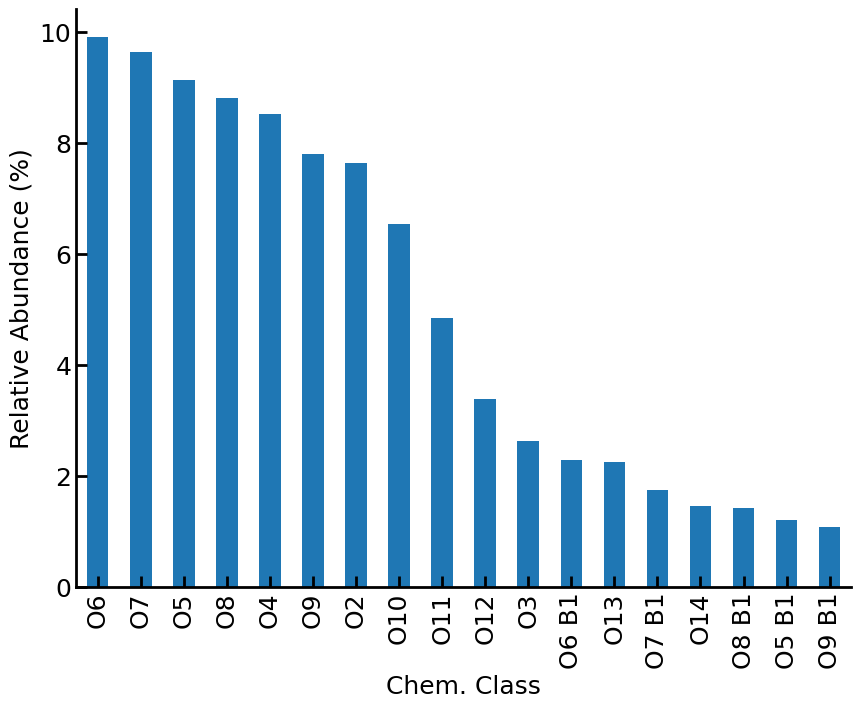

In [16]:
attributed_peaklist.plot.plot_classes(threshold=1)

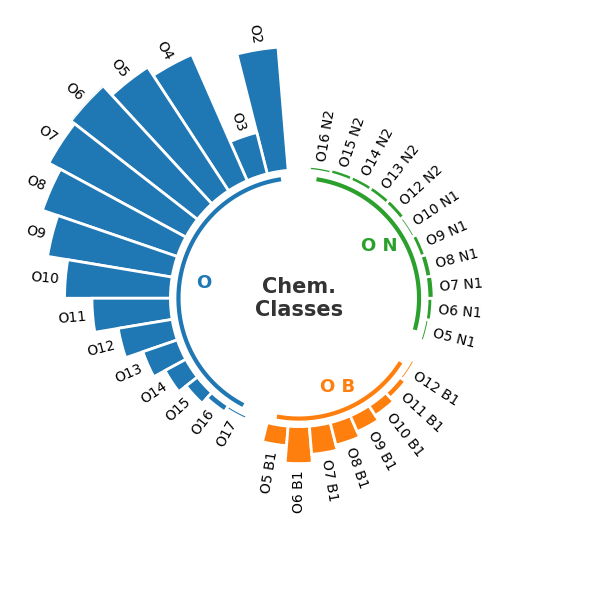

In [22]:
attributed_peaklist.plot.plot_classes_circular(threshold=.2)

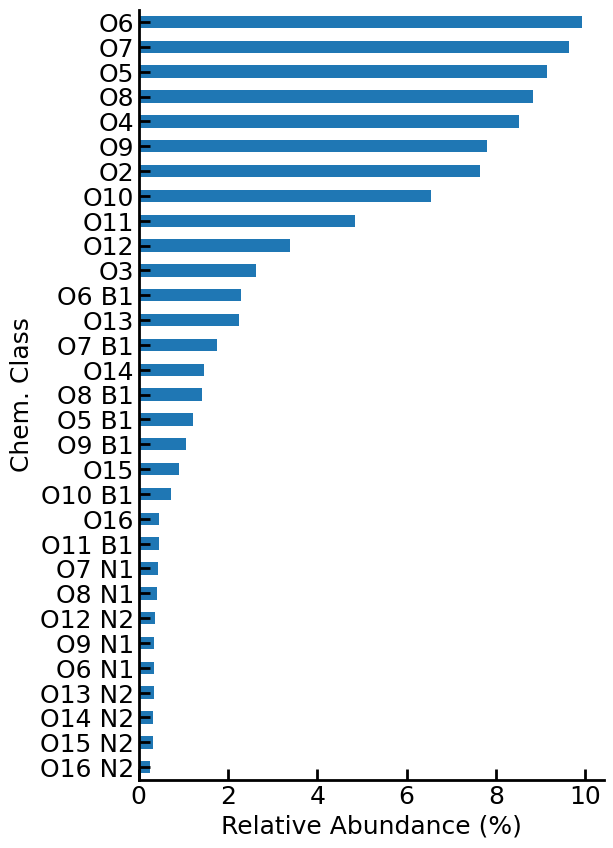

In [17]:
plt.figure(figsize=(6, 10))  # modify the figure size if needed
attributed_peaklist.plot.plot_classes(threshold=0.25, orientation="h")  # modify threshold to expand the classes

In [18]:
attributed_peaklist.plot.plot_dbe('O6', plot_type='points', markersize=90, non_integer_dbe=True)

### Use widgets to plot results

In [19]:
display_chem_classes(attributed_peaklist)

In [20]:
display_error(attributed_peaklist)